In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.models.cnf import CondRealNVP_v2
from bcnf.utils import get_dir
from bcnf.utils import load_config, load_data, sub_root_path
from bcnf.eval.calibration import compute_y_hat_ranks, compute_CDF_residuals

from bcnf.train.trainer_data_handler import TrainerDataHandler
from bcnf.train.utils import get_data_type

## Model

In [3]:
MODEL_NAME = f'trajectory_TRF_small'

In [4]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])
    config['data']['path'] = sub_root_path(config['data']['path']).replace('/train', '/test')
    print(config['data']['path'])

cnf = CondRealNVP_v2.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

cnf.eval();

/home/psaegert/Projects/bcnf/data/bcnf-data/fixed_data_render_2s_15FPS/test


In [5]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 128,129


In [6]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [7]:
T = 2
dt = 1/15

In [8]:
data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')
# data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='videos')

Loading data from directory: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it, file=fixed_data_render_2s_15FPS_5.pkl]


In [9]:
y, conditions = TrainerDataHandler().get_data_for_training(
    config,
    cnf.parameter_index_mapping,
    dtype=get_data_type(dtype=config["global"]["dtype"]),
    return_tensor_dataset=False)

print(f'{y.shape=}')
for condition in conditions:
    print(f'{condition.shape=}')

y.shape=torch.Size([1000, 19])
condition.shape=torch.Size([1000, 30, 3])


## Code Space

In [10]:
z = torch.empty(y.shape)
batch_size = 32

with torch.no_grad():
    for i in tqdm(range(0, len(y), batch_size)):
        z[i:i+batch_size] = cnf.forward(y[i:i+batch_size].to(device), *[c[i:i+batch_size].to(device) for c in conditions])

100%|██████████| 32/32 [00:00<00:00, 87.22it/s]


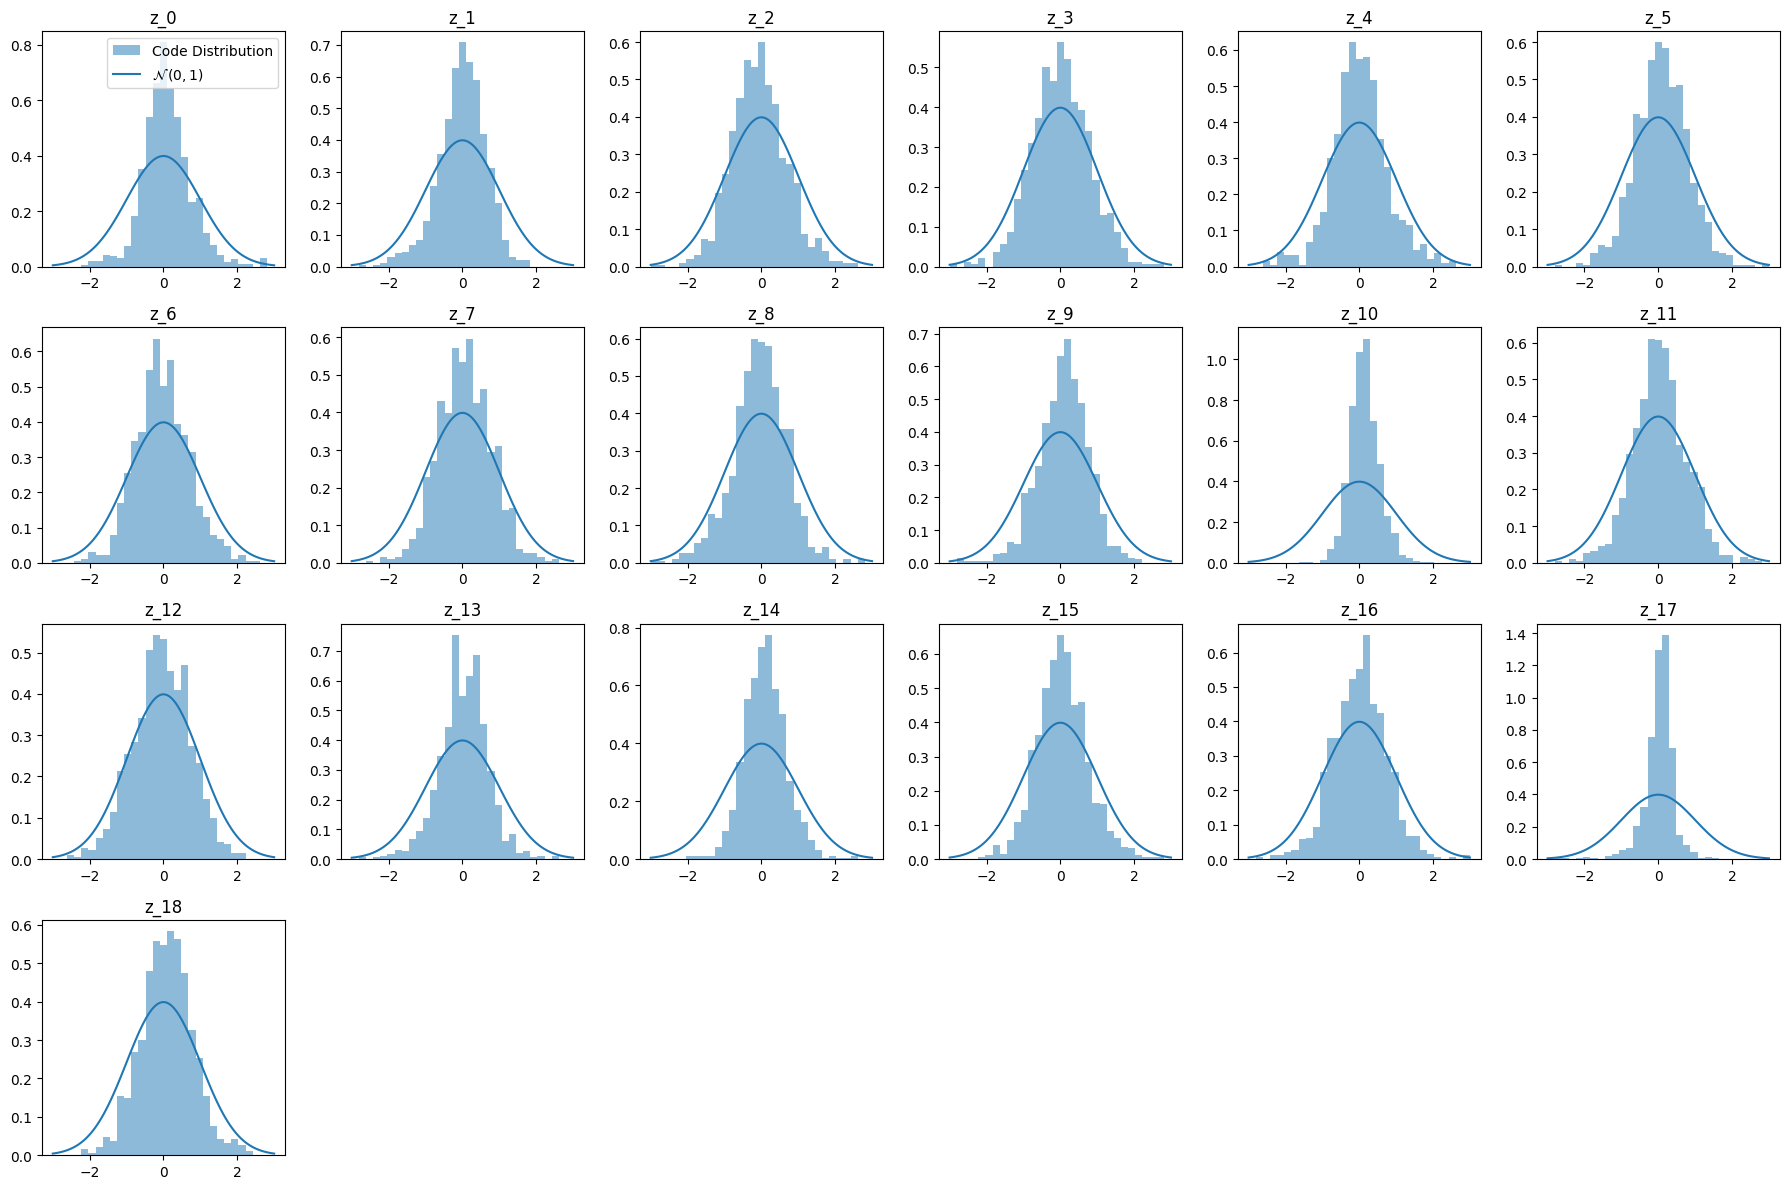

In [11]:
COLS = 6
ROWS = np.ceil(z.shape[1] / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))

for i in range(z.shape[1]):
    axes.flatten()[i].hist(z[:, i], alpha=0.5, color='C0', label='Code Distribution', bins=np.linspace(-3, 3, 32), density=True)
    axes.flatten()[i].set_title(f'z_{i}')

    # Plot the standard normal distribution
    x = np.linspace(-3, 3, 100)
    axes.flatten()[i].plot(x, np.exp(-x**2/2) / np.sqrt(2 * np.pi), label=r'$\mathcal{N}\,(0, 1)$', color='C0')

for i in range(z.shape[1], COLS * ROWS):
    axes.flatten()[i].axis('off')

axes[0, 0].legend()

fig.tight_layout();

## Calibration

In [12]:
M_SAMPLES = 10_000
example_id = 1

In [13]:
y_hat = cnf.sample(
    M_SAMPLES,
    *[c[example_id:example_id+1].to(device) for c in conditions],
    batch_size=16,
    outer=True,
    verbose=True)
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

Batch Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Batch Sampling: 100%|██████████| 1/1 [00:05<00:00,  5.42s/it]


(10000, 1, 19)

In [14]:
y_prior = y.to('cpu').detach().numpy()
y_prior.shape

(1000, 19)

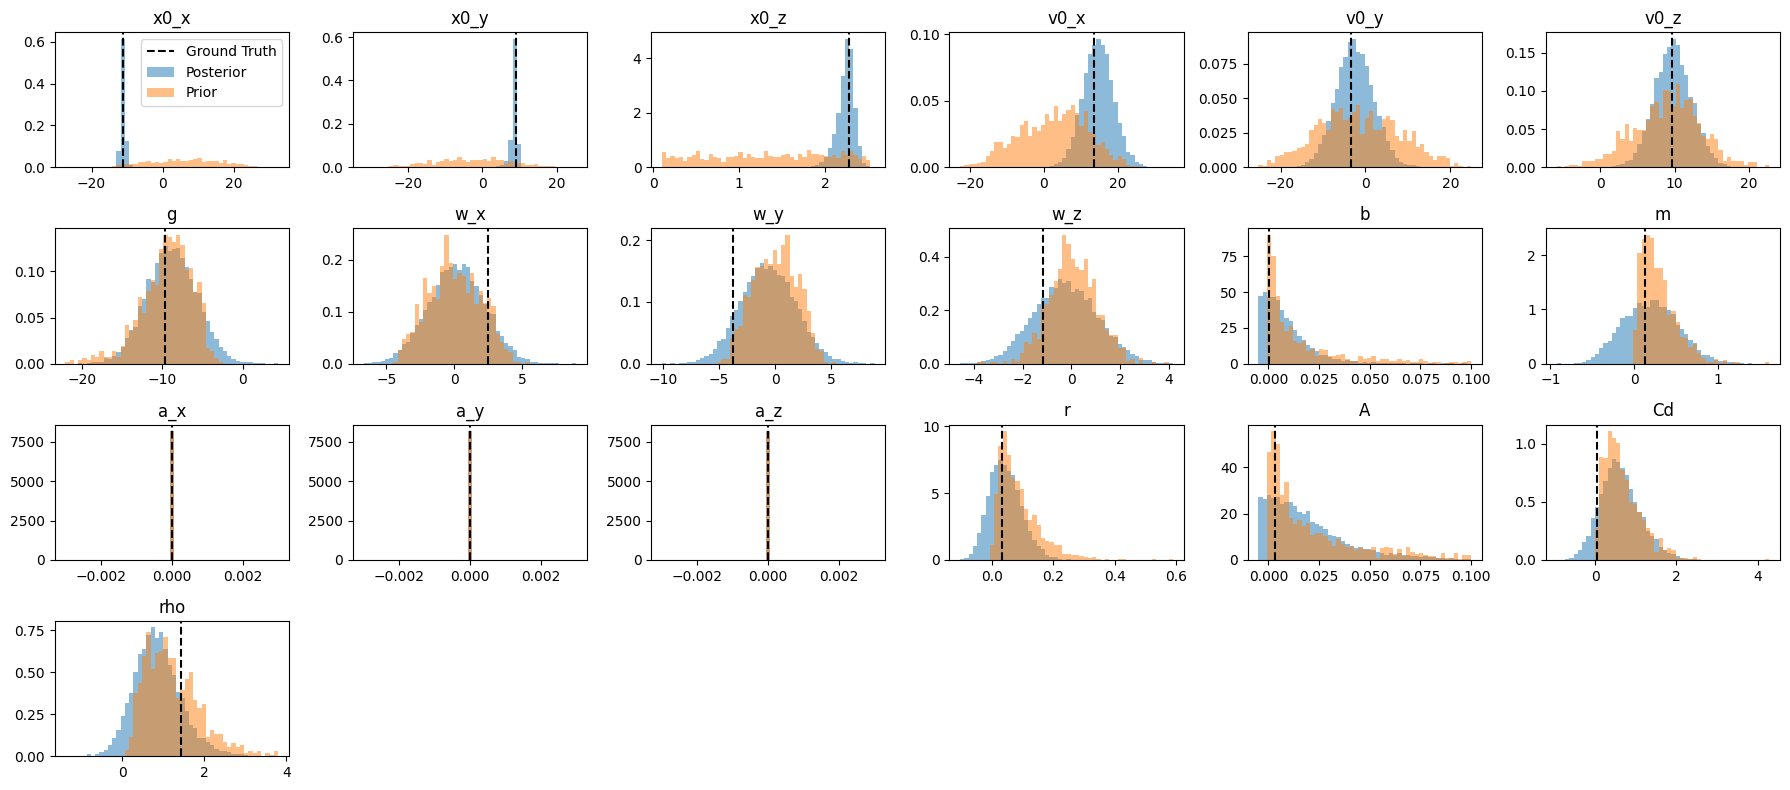

In [15]:
COLS = 6
ROWS = np.ceil(y_hat.shape[2] / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2))

for i, name in zip(range(y_hat.shape[2]), cnf.parameter_index_mapping.parameters):
    vmin = np.min(np.concatenate([y_hat[:, 0, i].flatten(), y_prior[:, i].flatten()]))
    vmax = np.max(np.concatenate([y_hat[:, 0, i].flatten(), y_prior[:, i].flatten()]))

    if name in ['b', 'A']:
        bins = np.linspace(-0.005, 0.1, 50)
        range_ = (-0.05, 0.25)
    elif name.startswith('a_'):
        bins = np.linspace(-0.003, 0.003, 50)
        range_ = (-0.003, 0.003)
    else:
        bins = 50
        range_ = (vmin, vmax)

    axes.flatten()[i].axvline(y[example_id, i].cpu().detach().numpy(), color='k', linestyle='--', label='Ground Truth')
    axes.flatten()[i].hist(y_hat[:, 0, i].flatten(), alpha=0.5, color='C0', label='Posterior', bins=bins, range=range_, density=True)
    axes.flatten()[i].set_title(name)

    # Show the prior
    axes.flatten()[i].hist(y_prior[:, i], alpha=0.5, color='C1', label='Prior', bins=bins, range=range_, density=True)

for i in range(y_hat.shape[2], COLS * ROWS):
    axes.flatten()[i].axis('off')

axes[0, 0].legend()

fig.tight_layout();

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'posterior_samples.png'))

# Calibration

In [16]:
from scipy.stats import binom

In [17]:
N_samples = conditions[0].shape[0]
M_samples = 10_000

In [18]:
y_cal_ranks = compute_y_hat_ranks(
    cnf,
    y,
    *[c for c in conditions],
    M_samples=M_samples,
    batch_size=64,
    sample_batch_size=64,
    device=device,
    output_device='cpu',
    verbose=True)

Batch Sampling:   0%|          | 0/16 [00:00<?, ?it/s]

Batch Sampling: 100%|██████████| 16/16 [00:35<00:00,  2.23s/it]


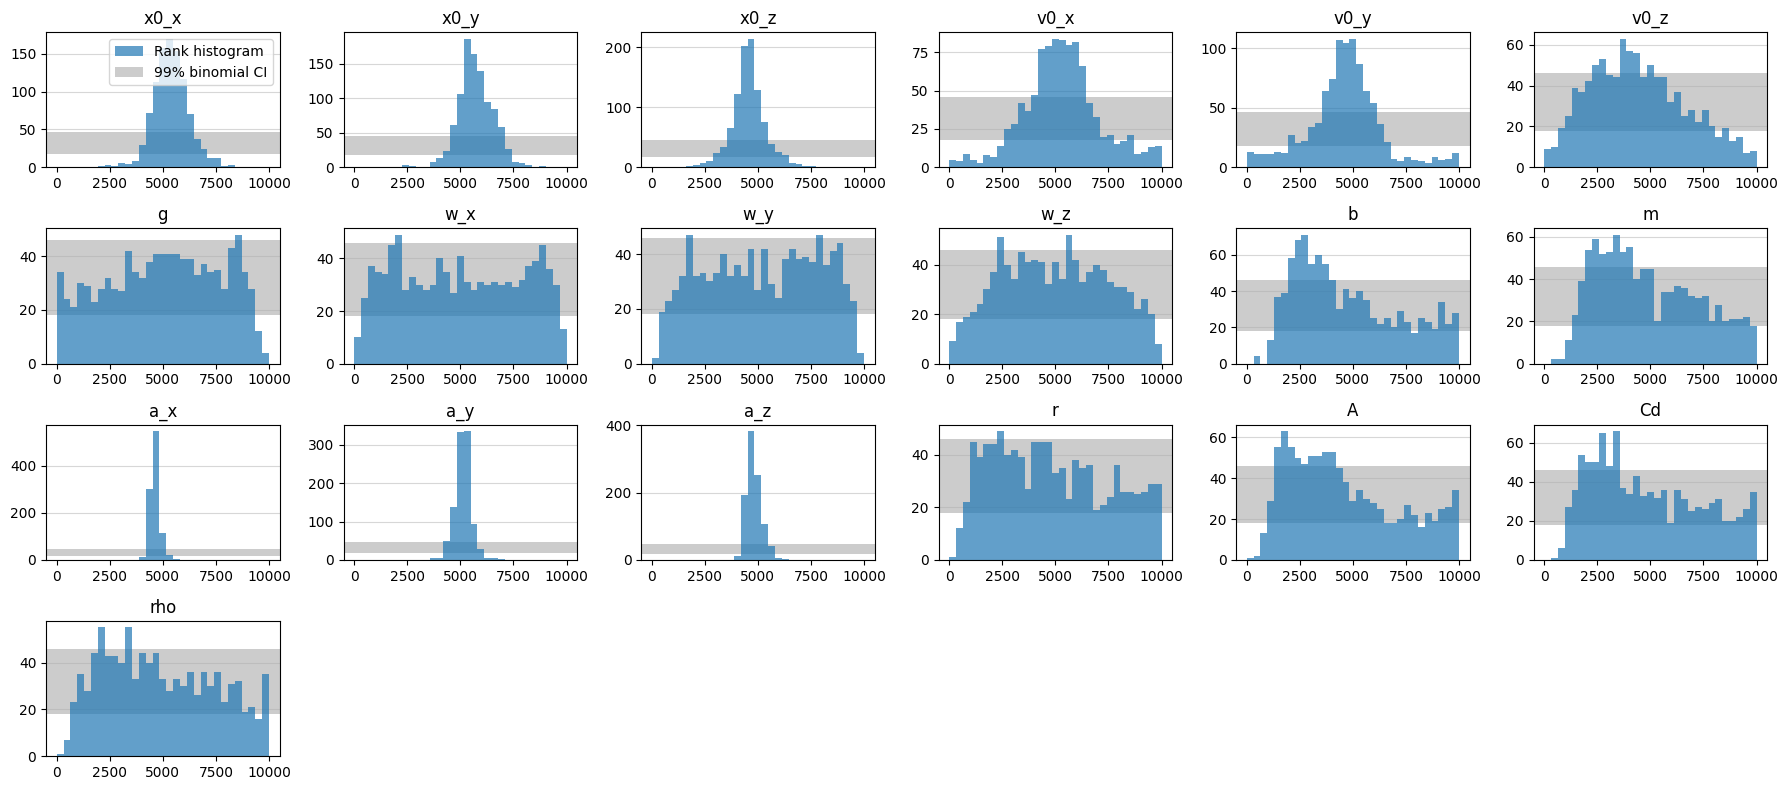

In [19]:
# Plot a histogram of the indices for each of the three parameters
COLS = 6
ROWS = np.ceil(y_cal_ranks.shape[1] / COLS).astype(int)

n_bins = 32
binomial_interval = 0.99

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2))

endpoints = binom.interval(binomial_interval, N_samples, 1 / n_bins)

n_bins_outliers = 0
n_bins_total = 0

for i, ax, name in zip(range(y_cal_ranks.shape[1]), axes.flatten(), cnf.parameter_index_mapping.parameters):
    hist = ax.hist(y_cal_ranks[:, i].detach().cpu().numpy(), bins=np.linspace(0, M_samples, n_bins), alpha=0.7, color='C0', zorder=2, label='Rank histogram')

    # Count how many bins are outside the interval
    n_bins_outliers += np.sum(hist[0] < endpoints[0]) + np.sum(hist[0] > endpoints[1])
    n_bins_total += n_bins

    ax.axhspan(endpoints[0], endpoints[1], facecolor="k", alpha=0.2, label=f'{binomial_interval * 100:.0f}% binomial CI')

    ax.set_title(name)

    ax.grid(axis='y', alpha=0.5, zorder=0)

axes[0, 0].legend()

for i in range(y_cal_ranks.shape[1], COLS * ROWS):
    axes.flatten()[i].axis('off')

fig.tight_layout()


plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'rank_histogram.png'))

In [20]:
print(f'Bins outside the interval: {n_bins_outliers} / {n_bins_total} ({n_bins_outliers / n_bins_total:.1%} vs {(1 - binomial_interval) * 100:.1f}% binomial interval)')

Bins outside the interval: 299 / 608 (49.2% vs 1.0% binomial interval)


In [21]:
t_linspace, scaled_residuals, confidence_interval = compute_CDF_residuals(
    y_hat_all_sorted_ranks=y_cal_ranks,
    M_samples=M_samples,
    sigma=3
)

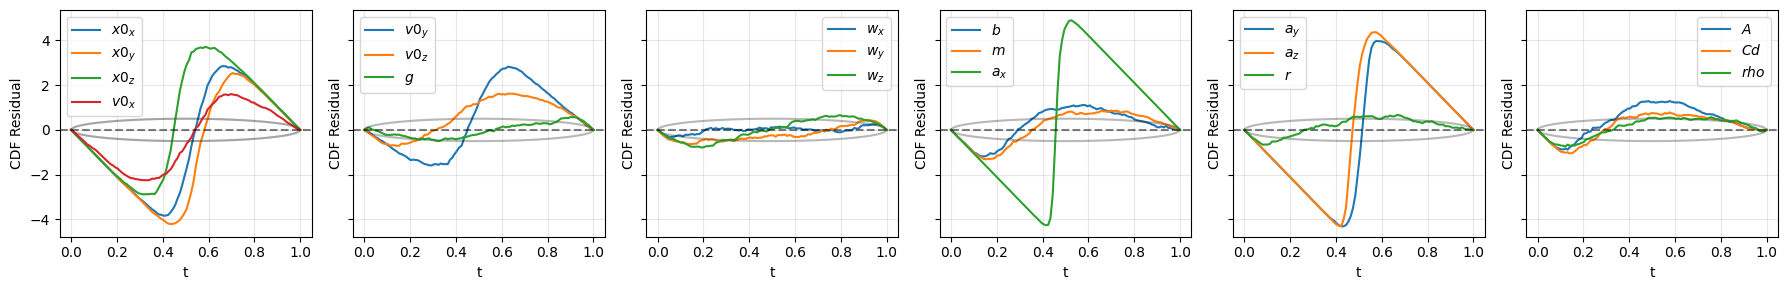

In [22]:
# Plot the residuals for X_0
n_curves_per_plot = 4
N_COLS = 6
N_ROWS = np.ceil(np.ceil(y_cal_ranks.shape[1] / n_curves_per_plot) / N_COLS).astype(int)

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 3, N_ROWS * 3), sharey=True)

for indices, ax, param_names in zip(
    np.array_split(range(y_cal_ranks.shape[1]), N_ROWS * N_COLS),
    axes.flatten(),
    np.array_split(cnf.parameter_index_mapping.parameters, N_ROWS * N_COLS)):
    
    for j, param_name in zip(indices, param_names):
        ax.plot(t_linspace, scaled_residuals[j, :], label=f"${param_name}$")

        ax.plot(t_linspace, confidence_interval, color='black', alpha=0.1)
        ax.plot(t_linspace, -confidence_interval, color='black', alpha=0.1)

    ax.set_xlabel("t")
    ax.set_ylabel("CDF Residual")

    ax.axhline(0, color='black', linestyle='--', alpha=0.5)

    ax.legend()

    # ylim = max(np.abs(scaled_residuals[indices, :].min()), np.abs(scaled_residuals[indices, :].max()))

    # ax.set_ylim(-ylim * 1.5, ylim * 1.5)

    ax.grid(alpha=0.3)

fig.tight_layout()


plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'CDF_residuals.png'))